In [517]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [535]:
def pos(s, state_space):
    return tuple(zip(*np.where(state_space == s)))[0]

In [519]:
def get_reward(reward_fn, s, state_space):
    return reward_fn[pos(s, state_space)]

In [520]:
def get_neighbors(s, state_space):
    
    dim = state_space.shape[0]
    i, j = pos(s, state_space)
    neighbors = [state_space[i][j]]
    
    if i-1 >= 0: neighbors.append(state_space[i-1][j])
    if i+1 < dim: neighbors.append(state_space[i+1][j])
    if j-1 >= 0: neighbors.append(state_space[i][j-1])
    if j+1 < dim: neighbors.append(state_space[i][j+1])
        
    return neighbors

In [521]:
def get_cell_type(i, j, dim):
    
    if (i,j) in [(0, 0), (0, dim), (dim, 0), (dim, dim)]:
        return 'corner'
    
    elif i == 0 or j == 0 or i == dim or j == dim:
        return 'edge'
    
    else:
        return 'non-boundary'

In [522]:
def get_action_results(A, s, S, state_space, w, reward_fn, gamma, V):
    
    action_results = {}
    for a in A:
        action_results[a] = 0
        neighbors = get_neighbors(s, state_space)
        for s_dash in neighbors:
            p = get_transition_probability(state_space, s, s_dash, a, w, A)
            r = get_reward(reward_fn, s_dash, state_space)
            action_results[a] += p * (r + gamma * V[pos(s_dash, state_space)])

    return action_results

In [523]:
def get_relation(i, j, i_d, j_d):
    
    if i == i_d:
        if j_d == j-1: 
            return 'L'
        elif j_d == j+1:
            return 'R'
        
        elif j_d == j:
            return 'S'
   
    elif j == j_d:
        if i_d == i-1:
            return 'U'
        elif i_d == i+1:
            return 'D'

In [524]:
def chk_edge_dir(i, j, a, n):
    return (i, a) in [(0, 'U'), (n, 'D')] or (j, a) in [(0, 'L'), (n, 'R')]

def chk_corner_dir(i, j, a, n):
    return (i, j, a) in [(0, 0, 'L'), (0, 0, 'U'),
                        (0, n, 'R'), (0, n, 'U'),
                        (n, 0, 'D'), (n, 0, 'L'),
                        (n, n, 'D'), (n, n, 'R')]

In [525]:
def get_transition_probability(state_space, s, s_dash, a, w, A):
    
    
    dim = state_space.shape[0] - 1
    
    i, j = pos(s, state_space)
    i_d, j_d = pos(s_dash, state_space)
    
    
    s_dash_dir = get_relation(i, j, i_d, j_d)
    cell_type = get_cell_type(i, j, dim)
    
    if not s_dash_dir:
        return 0
    
    elif s_dash_dir == a:
        return 1 - w + w/4
        
    elif s_dash_dir in A:
        return w/4
         
    
    elif (i, j) != (i_d, j_d):
        return 0
    
    
    elif cell_type == 'corner':
        if chk_corner_dir(i, j, a, dim):
            return 1 - w + w/4 + w/4
        else:
            return w/4 + w/4
            
    
    elif cell_type == 'edge':
        if chk_edge_dir(i, j, a, dim):
            return 1 - w + w/4
        else:
            return w/4
            
    elif cell_type == 'non-boundary':
        return 0  

    return 0

In [526]:
def get_optimal_state_value_fn(reward_fn, S, A, gamma, eps, state_space, w):
    
    #initialization
    V = np.zeros(state_space.shape)
        
    #estimation
    delta = float("inf")
    
    while delta > eps:

        delta = 0
        
        for s in S:
            s_index = pos(s, state_space)
            v = V[s_index]
            action_results = get_action_results(A, s, S, state_space, w, reward_fn, gamma, V)
            V[s_index] = max(action_results.values())
            delta = max(delta, np.fabs(v - V[s_index]))
            
    return V   

In [527]:
def get_optimal_policy(reward_fn, S, A, gamma, state_space, w, V):
    
    #computation
    policy = np.zeros(state_space.shape, dtype = 'object')
    
    for s in S:
        action_results = get_action_results(A, s, S, state_space, w, reward_fn, gamma, V)
        policy[pos(s, state_space)] = arrows[max(action_results, key = action_results.get)]
        
    return policy

In [528]:
reward_fn_dim = 10

In [529]:
reward_fn1 = np.zeros((reward_fn_dim,reward_fn_dim))
reward_fn1[reward_fn_dim -1 , reward_fn_dim -1] = 1.0

In [530]:
reward_fn2 = np.zeros((reward_fn_dim,reward_fn_dim))
negative_reward_indices = [(1,4), (1,5), (1,6),
                          (2,4), (2,6),
                          (3,4), (3,6), (3,7), (3,8),
                          (4,4), (4,8),
                          (5,4), (5,8),
                          (6,4), (6,8),
                          (7,6), (7,7), (7,8),
                          (8,6)]

for index in negative_reward_indices:
    reward_fn2[index] = -100.0
    
reward_fn2[reward_fn_dim - 1, reward_fn_dim - 1] = 10.0

<h2>Question 1</h2>

Heat map of reward function 1


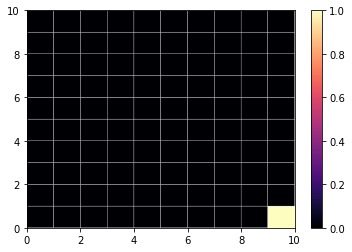

In [531]:
print("Heat map of reward function 1")
plt.pcolor(np.flipud(reward_fn1), edgecolors = 'white', cmap = 'magma')
plt.colorbar()
plt.show()

Heat map of reward function 2


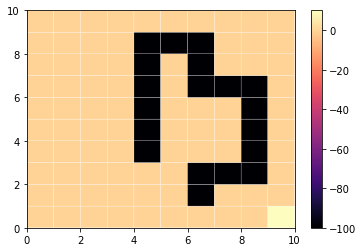

In [532]:
print("Heat map of reward function 2")
plt.pcolor(np.flipud(reward_fn2), edgecolors = 'white', cmap = 'magma')
plt.colorbar()
plt.show()

<h2>Question 2</h2>

In [533]:
S = range(0, 100)
state_space = np.transpose(np.array(S).reshape(10,10))
A = ['U', 'D', 'L', 'R']
arrows = {'U' : u'\u2191', 'D' : u'\u2193', 'L' : u'\u2190', 'R' : u'\u2192'}
num_states = 100
w = 0.1
gamma = 0.8
P = {}

<h2> Question 2 </h2>

In [536]:
optimal_state_values_r1 = get_optimal_state_value_fn(reward_fn1, S, A, gamma, 0.01, state_space, w)

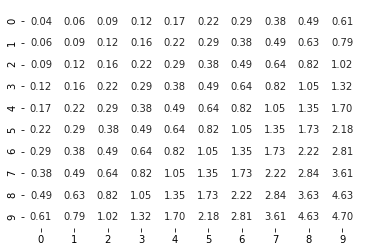

In [537]:
sns.heatmap(state_space, annot=optimal_state_values_r1, fmt='.2f', cbar = False, 
            cmap=ListedColormap(['white']))

<h2> Question 3 </h2>

Heat map of Optimal State Values for reward 1


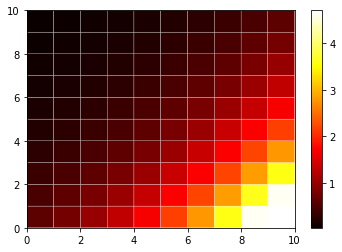

In [538]:
print("Heat map of Optimal State Values for reward 1")
plt.pcolor(np.flipud(optimal_state_values_r1), edgecolors = 'white', cmap = 'hot')
plt.colorbar()
plt.show()

<h2>Question 5</h2>

In [539]:
optimal_policy_r1 = get_optimal_policy(reward_fn1, S, A, gamma, state_space, w, optimal_state_values_r1)

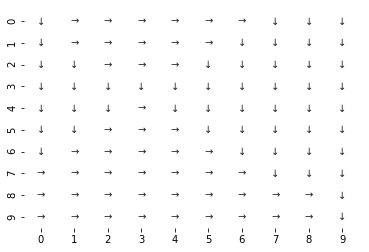

In [540]:
sns.heatmap(state_space, annot=optimal_policy_r1, fmt='', cbar = False, 
            cmap=ListedColormap(['white']))

<h2> Question 6 </h2>

In [541]:
optimal_state_values_r2 = get_optimal_state_value_fn(reward_fn2, S, A, gamma, 0.01, state_space, w)

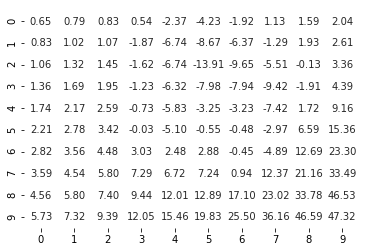

In [542]:
sns.heatmap(state_space, annot=optimal_state_values_r2, fmt='.2f', cbar = False, 
            cmap=ListedColormap(['white']))

<h2> Question 7 </h2>

Heat map of Optimal State Values for reward 2


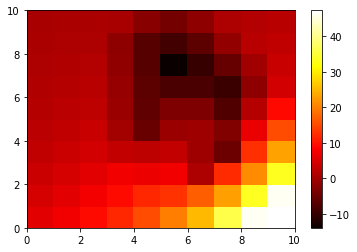

In [543]:
print("Heat map of Optimal State Values for reward 2")
plt.pcolor(np.flipud(optimal_state_values_r2), cmap = 'hot')
plt.colorbar()
plt.show()

<h2> Question 9 </h2>

In [544]:
optimal_policy_r2 = get_optimal_policy(reward_fn2, S, A, gamma, state_space, w, optimal_state_values_r2)

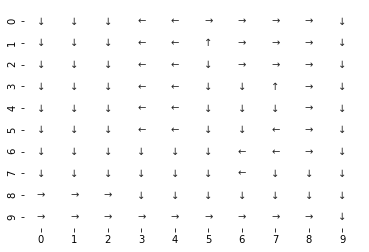

In [545]:
sns.heatmap(state_space, annot=optimal_policy_r2, fmt='', cbar = False, 
            cmap=ListedColormap(['white']))